# Car Detection

We will implement car object detection which uses pre-trained YOLO ("You Only Look Once") model which has an application in self driving cars. This algorithm requires only one forward propagation pass through the network to make predictions. We will be detecting objects of 80 classes like cars, passengers, traffic lights, etc, and drawing bounding boxes across them along with their probability. We will select boxes according to class scores and non max suppression.

### Loading the packages and dependencies.

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
import PIL
from PIL import ImageFont, ImageDraw, Image
from matplotlib.pyplot import imshow

### Model Details
- Input is an image of shape (m,608,608,3).
- Output is (p_c, b_x, b_y, b_h, b_w, c) representing probability of object present and bounding box parameters and c is probability of class, 80 dimensional vector if 80 classes.
- Anchor boxes are 5 and is the second last dimension in yolo model's encoded output.
- The YOLO architecture is: Image (m, 608, 608, 3) -> Deep CNN -> Encoding (m, 19, 19, 5, 85).
- The last two dimensions of (19, 19, 5, 85) encoding are flattened so the output of the Deep CNN is (19, 19, 425).
- To reduce number of boxes, we filter them firstly based on their class scores(probab there is a object (p_c) * probab the object is of the class(c_i)). Then we apply non max suppression by selecting only one box when several boxes overlap with each other and detect the same object using intersection over union threshold value defined.

We are going to use a pre-trained model and test it on the car detection dataset.  

### Defining Classes, Anchors and Image Shape

We're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is taken from files. The car detection dataset has images of shape 720x1280, which are pre-processed into 608x608 images.

In [2]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) 

###  Loading YOLO Pre-trained Model

We are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5" and use converted weights.

In [3]:
yolo_model = load_model("model_data/", compile=False)

Summary of the layers of the model

In [4]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Filtering boxes on Class Scores

A function which will apply a filter by thresholding, which means discarding all the boxes whose class score (probab of object present * max probab of class) is below the defined threshold. 

In [5]:
def filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    
    # Find box scores
    box_scores =  box_confidence*box_class_probs
    
    # Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1, keepdims=False)
    
    # Create a filtering mask based on box_class_scores using threshold
    filtering_mask = (box_class_scores>=threshold)
    
    # Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

### Non-max Suppression

There are a lot of overlapping boxes remaining after filtering using thresholding. To reduce it further, non-maximum suppression (NMS) filter is applied which will remove all boxes that have a large overlap with the selected boxes.

Steps:
- Select the box that has the highest score.
- Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= iou_threshold).
- Iterate until there are no more boxes with a lower score than the currently selected box.

In [6]:
def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.6):
   
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')
    
    # Getting the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(
    boxes, scores, max_boxes_tensor, iou_threshold=0.5)
    
    # Selecting only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

### Combine Functions

Function taking the output of the Yolo deep CNN (the 19x19x5x85 dimensional encoding) and filters through all the boxes by converting it to required predicted boxes along with their scores, box coordinates and classes.

In [7]:
def evaluate_boxes(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.5, iou_threshold=.6):
    
    # Get outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)
    #concatenate y_min, x_min, y_max, x_max 
    boxes= tf.keras.backend.concatenate([ box_mins[..., 1:2], box_mins[..., 0:1], box_maxes[..., 1:2], box_maxes[..., 0:1] ])

    # Score-filtering 
    scores, boxes, classes = filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape
    boxes = scale_boxes(boxes, image_shape)

    # Non-max suppression
    scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

## Testing model on images
### Predict

We need to convert output of the model (m, 19, 19, 5, 85) to usable bounding boxes using yolo_head. To perform filtering and selecting only the best boxes, we will call evaluate function which gives out_scores, out_boxes, out_classes.


In [8]:
def predict_objects(image_file):

    # Preprocess image, open the image file and scale, reshape and normalize the image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = evaluate_boxes(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('There are {} boxes'.format(len(out_boxes)))
    # Generate colors for drawing bounding boxes
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

**Running predict on the "traffic.jpg" image to detect objects.**

There are 10 boxes
car 0.79 (577, 335) (851, 634)
car 0.77 (277, 325) (571, 717)
car 0.73 (444, 258) (608, 387)
car 0.67 (351, 215) (457, 278)
car 0.67 (97, 250) (230, 331)
car 0.66 (488, 209) (589, 273)
person 0.65 (889, 287) (970, 428)
motorbike 0.65 (1018, 314) (1072, 394)
motorbike 0.64 (888, 336) (966, 462)
car 0.60 (698, 241) (790, 324)


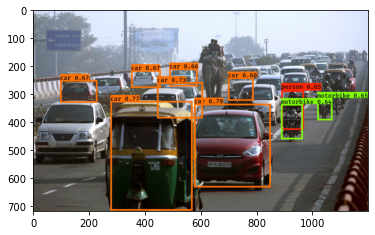

In [10]:
out_scores, out_boxes, out_classes = predict_objects("traffic.jpg")

**Running predict on continuous images of the video to detect objects.**

There are 5 boxes
car 0.82 (1, 358) (183, 427)
car 0.79 (1103, 300) (1271, 356)
truck 0.64 (666, 274) (1063, 392)
traffic light 0.48 (215, 186) (238, 222)
traffic light 0.43 (737, 142) (774, 197)


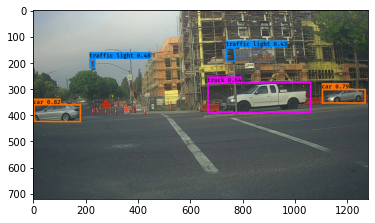

In [11]:
out_scores, out_boxes, out_classes = predict_objects("0017.jpg")

There are 6 boxes
car 0.77 (340, 339) (553, 401)
car 0.76 (71, 362) (242, 419)
truck 0.60 (717, 276) (1055, 389)
car 0.46 (0, 367) (31, 412)
traffic light 0.42 (733, 142) (771, 196)
traffic light 0.42 (213, 188) (233, 219)


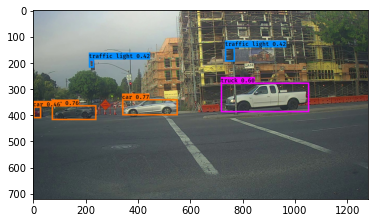

In [12]:
out_scores, out_boxes, out_classes = predict_objects("0018.jpg")

There are 3 boxes
car 0.85 (16, 377) (450, 559)
truck 0.64 (685, 275) (1050, 396)
traffic light 0.43 (201, 188) (224, 223)


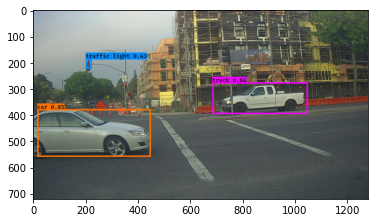

In [13]:
out_scores, out_boxes, out_classes = predict_objects("0019.jpg")